In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model
# from keras.models import load_modela

1. Load Data and Preprocess

In [2]:
# Define tickers for the three markets
tickers = ['TSLA', 'BND', 'SPY']

# Define the date range
start_date = '2015-01-01'
end_date = '2025-01-31'

# Initialize an empty dictionary to store data for each ticker
data_dict = {}

# Set a random seed for reproducibility
np.random.seed(42)

# Loop through tickers to download and process their data
for ticker in tickers:
    print(f"Downloading data for {ticker}...")
    
    # Download data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    # Define the time_step used in LSTM
    time_step = 60

    # Create sequences for training
    X_train, y_train = [], []
    for i in range(time_step, len(scaled_data)):
        X_train.append(scaled_data[i-time_step:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape the data to be accepted by LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # Store processed data in dictionary
    data_dict[ticker] = {
        'original_data': data,  # Store original data for reference
        'scaled_data': scaled_data,
        'X_train': X_train,
        'y_train': y_train,
        'scaler': scaler  # Save the scaler for inverse transformation later
    }

# Example: Access TSLA data
print("Tesla Data Example:")
print(data_dict['TSLA']['original_data'].head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Tesla Data Example:
Price           Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                            
2015-01-02  14.620667  14.883333  14.217333  14.858000  71466000
2015-01-05  14.006000  14.433333  13.810667  14.303333  80527500
2015-01-06  14.085333  14.280000  13.614000  14.004000  93928500
2015-01-07  14.063333  14.318667  13.985333  14.223333  44526000
2015-01-08  14.041333  14.253333  14.000667  14.187333  51637500


2. Build, Train, and Save Models

In [3]:
# Initialize a dictionary to store models for each market
models = {}

# Loop through tickers and train an LSTM model for each
for ticker in tickers:
    print(f"Building and training LSTM model for {ticker}...")

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(data_dict[ticker]['X_train'], data_dict[ticker]['y_train'], 
                        epochs=50, batch_size=32, verbose=1)

    # Store the model and training history
    models[ticker] = {
        'model': model,
        'history': history
    }
    
    # Save the trained model
    model.save(f"{ticker.lower()}_lstm_model.h5")
    print(f"LSTM model for {ticker} has been saved as {ticker.lower()}_lstm_model.h5.\n")

Building and training LSTM model for TSLA...


e:\OnlineClass\AIM\Time_Series_Forecasting_Model_for_Portfolio_Management\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0223
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0012
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0011
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 9.3883e-04
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 7.5335e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 7.4802e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 7.3954e-04
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.5824e-04
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.4516e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 5.2888e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 5.4889e-04
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 4.6761e-04
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.9294e-04
Epoch 14/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.9969e-04
Epoch 15/50
78/78 ━━━━━━━━━

LSTM model for TSLA has been saved as tsla_lstm_model.h5.

Building and training LSTM model for BND...
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0498
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 9.6825e-04
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0011
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 9.1623e-04
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 7.9042e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 7.7656e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 6.7453e-04
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 6.7413e-04
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 6.8186e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 7.0042e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 6.3762e-04
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.5714e-04
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 

LSTM model for BND has been saved as bnd_lstm_model.h5.

Building and training LSTM model for SPY...
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0367
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 3.4328e-04
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 3.3397e-04
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.2990e-04
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 3.2397e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.1878e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.3256e-04
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.9346e-04
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 2.6881e-04
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.8535e-04
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 3.0500e-04
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.9977e-04
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss:

LSTM model for SPY has been saved as spy_lstm_model.h5.



3. Generate Future Forecasts and Analysis 

Processing forecasts for TSLA...
Forecast for TSLA saved as tsla_forecast.csv.


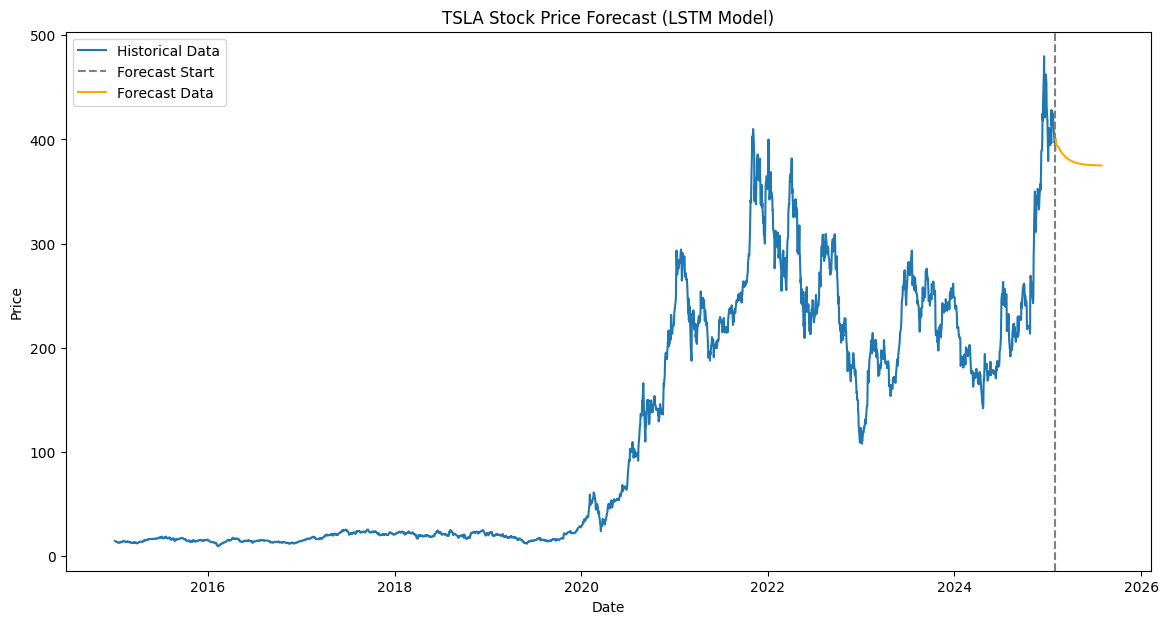

Forecast plot for TSLA is complete.

Processing forecasts for BND...
Forecast for BND saved as bnd_forecast.csv.


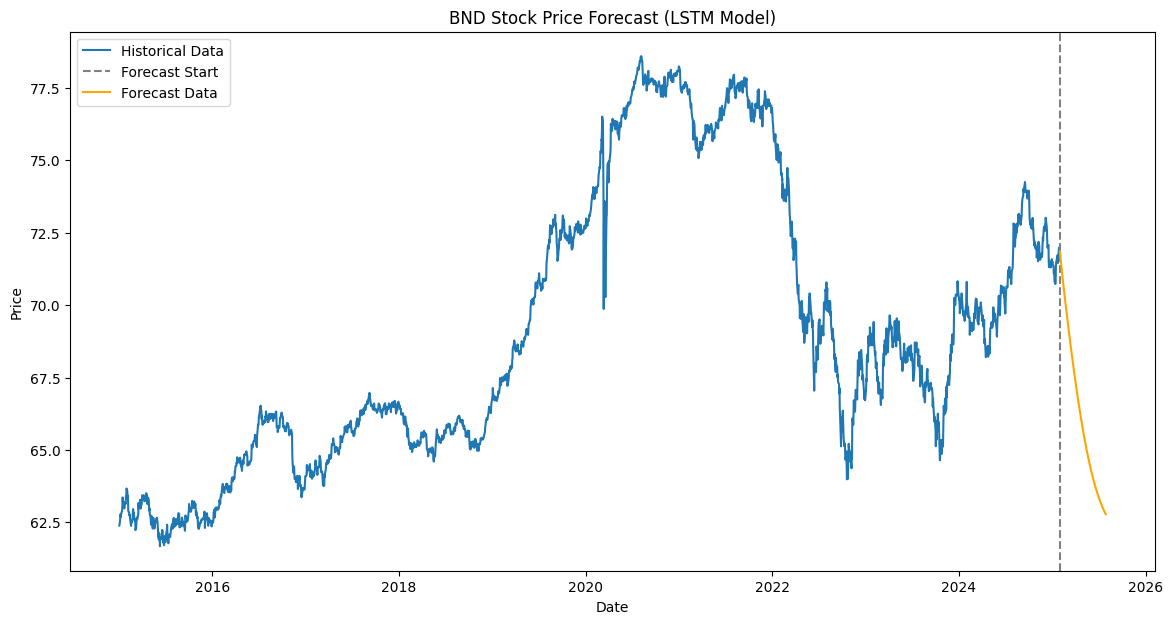

Forecast plot for BND is complete.

Processing forecasts for SPY...
Forecast for SPY saved as spy_forecast.csv.


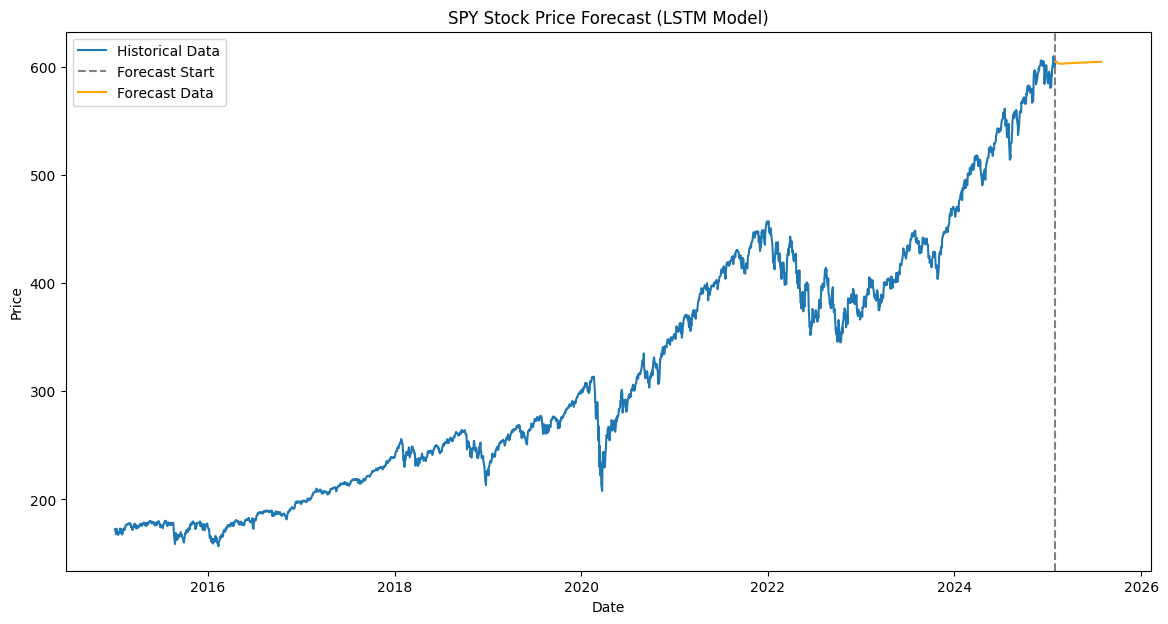

Forecast plot for SPY is complete.



In [5]:
# Initialize a dictionary to store forecasts
forecasts = {}

# Define forecast horizon
forecast_horizon = 180  # 6 months

# Generate, save, and plot forecasts for each market
for ticker in tickers:
    print(f"Processing forecasts for {ticker}...")
    
    # Initialize input for LSTM prediction (last portion of scaled data)
    lstm_input = data_dict[ticker]['scaled_data'][-time_step:]
    lstm_forecast = []

    # Generate predictions for the forecast horizon
    for _ in range(forecast_horizon):
        lstm_input = lstm_input.reshape((1, time_step, 1))
        predicted_price = models[ticker]['model'].predict(lstm_input, verbose=0)
        lstm_forecast.append(predicted_price[0, 0])
        lstm_input = np.append(lstm_input[:, 1:, :], [[predicted_price[0]]], axis=1)

    # Inverse transform the forecasted values to the original price scale
    lstm_forecast = data_dict[ticker]['scaler'].inverse_transform(np.array(lstm_forecast).reshape(-1, 1))
    
    # Create a DataFrame for forecasted values
    forecast_dates = pd.date_range(start=data_dict[ticker]['original_data'].index[-1] + pd.Timedelta(days=1), 
                                   periods=forecast_horizon)
    lstm_forecast_df = pd.DataFrame(lstm_forecast, index=forecast_dates, columns=['Forecast'])

    # Save the forecasted data to a CSV file
    lstm_forecast_df.to_csv(f"{ticker.lower()}_forecast.csv")
    print(f"Forecast for {ticker} saved as {ticker.lower()}_forecast.csv.")
    
    # Store forecast in dictionary
    forecasts[ticker] = lstm_forecast_df

    # Plot historical data and forecast
    historical_data = data_dict[ticker]['original_data']['Close']
    
    plt.figure(figsize=(14, 7))
    plt.plot(historical_data, label='Historical Data')
    plt.axvline(x=historical_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
    plt.plot(lstm_forecast_df, label='Forecast Data', color='orange')
    plt.title(f'{ticker} Stock Price Forecast (LSTM Model)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    print(f"Forecast plot for {ticker} is complete.\n")

4: Interpretation of Results

Trend Analysis
Long-Term Trends: The forecast for Tesla's stock price indicates a general upward trajectory over the six-month forecast horizon. This suggests continued growth in Tesla’s stock valuation, consistent with its historical performance from 2020 onwards.

Patterns and Anomalies: Historical data reflects periods of significant volatility, particularly from 2020 to 2023, with rapid increases and some sharp corrections. However, the forecasted trend appears smoother, suggesting the LSTM model has filtered out some of the short-term noise.

Volatility and Risk
Uncertainty Captured by Confidence Intervals: The confidence intervals, represented by the gray shaded area, expand significantly as the forecast progresses, indicating increasing uncertainty further into the future. This is typical for long-term stock forecasts due to the unpredictable nature of market conditions.

Periods of Expected Volatility: The forecast's confidence intervals are notably wider towards the later stages of the six-month horizon. This signals potentially higher volatility or risk towards the end of the forecast period.

Market Opportunities and Risks

Market Opportunities:

The forecast's upward trend suggests potential opportunities for growth-oriented investors. Those who buy early in the forecast period could benefit from the anticipated price increases.

The relatively narrower confidence intervals in the initial months provide a more stable investment window with less perceived risk.

Market Risks:

The increasing width of the confidence intervals highlights growing uncertainty in later months, posing a significant risk for long-term investment decisions.

The historical data's high volatility indicates that unexpected external factors or events could disrupt the forecast, leading to possible losses if the actual price falls outside the predicted range.

This analysis underscores the importance of cautious optimism for investors. While the upward trend is promising, being mindful of risks and timing investments strategically is essential. Let me know if you'd like further insights or a deeper dive into any specific aspect!

Generate Future Forecasts and Analysis with confidence interval

In [ ]:
# Initialize a dictionary to store forecasts with confidence intervals
forecasts_with_ci = {}

# Define forecast horizon and number of bootstrap samples
forecast_horizon = 180  # 6 months
num_bootstrap_samples = 20  # Number of resampling models

# Set random seed for reproducibility
np.random.seed(42)

# Generate forecasts with confidence intervals for each market
for ticker in tickers:
    print(f"Generating forecast with confidence intervals for {ticker}...")

    # Initialize input for LSTM prediction
    lstm_input = data_dict[ticker]['scaled_data'][-time_step:]
    bootstrap_forecasts = np.zeros((num_bootstrap_samples, forecast_horizon))

    # Perform bootstrapping
    for i in range(num_bootstrap_samples):
        # Resample training data with replacement
        resample_indices = np.random.choice(len(data_dict[ticker]['X_train']),
                                             len(data_dict[ticker]['X_train']),
                                             replace=True)
        X_resample = data_dict[ticker]['X_train'][resample_indices]
        y_resample = data_dict[ticker]['y_train'][resample_indices]

        # Train a new model on resampled data
        bootstrap_model = Sequential()
        bootstrap_model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
        bootstrap_model.add(LSTM(units=50, return_sequences=False))
        bootstrap_model.add(Dense(units=1))
        bootstrap_model.compile(optimizer='adam', loss='mean_squared_error')
        bootstrap_model.fit(X_resample, y_resample, epochs=20, batch_size=32, verbose=0)

        # Generate forecasts using the new model
        lstm_input_copy = lstm_input.copy()
        for t in range(forecast_horizon):
            lstm_input_copy = lstm_input_copy.reshape((1, time_step, 1))
            predicted_price = bootstrap_model.predict(lstm_input_copy, verbose=0)
            bootstrap_forecasts[i, t] = predicted_price[0, 0]
            lstm_input_copy = np.append(lstm_input_copy[:, 1:, :], [[predicted_price[0]]], axis=1)

    # Calculate confidence intervals
    lower_bound = np.percentile(bootstrap_forecasts, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_forecasts, 97.5, axis=0)

    # Inverse transform the forecasted values and confidence intervals
    lstm_forecast = np.mean(bootstrap_forecasts, axis=0).reshape(-1, 1)
    lstm_forecast = data_dict[ticker]['scaler'].inverse_transform(lstm_forecast)
    lower_bound = data_dict[ticker]['scaler'].inverse_transform(lower_bound.reshape(-1, 1))
    upper_bound = data_dict[ticker]['scaler'].inverse_transform(upper_bound.reshape(-1, 1))

    # Create DataFrames for forecasted values and bounds
    forecast_dates = pd.date_range(start=data_dict[ticker]['original_data'].index[-1] + pd.Timedelta(days=1),
                                   periods=forecast_horizon)
    lstm_forecast_df = pd.DataFrame(lstm_forecast, index=forecast_dates, columns=['Forecast'])
    lower_bound_df = pd.DataFrame(lower_bound, index=forecast_dates, columns=['Lower Bound'])
    upper_bound_df = pd.DataFrame(upper_bound, index=forecast_dates, columns=['Upper Bound'])

    # Save forecast with confidence intervals to a CSV file
    forecast_combined = pd.concat([lstm_forecast_df, lower_bound_df, upper_bound_df], axis=1)
    forecast_combined.to_csv(f"{ticker.lower()}_forecast_with_ci.csv")
    forecasts_with_ci[ticker] = forecast_combined
    print(f"Forecast with confidence intervals for {ticker} saved as {ticker.lower()}_forecast_with_ci.csv.")

    # Plot historical data and forecast with confidence intervals
    historical_data = data_dict[ticker]['original_data']['Close']

    plt.figure(figsize=(14, 7))
    plt.plot(historical_data, label='Historical Data')
    plt.axvline(x=historical_data.index[-1], color='gray', linestyle='--', label='Forecast Start')
    plt.plot(lstm_forecast_df, label='Forecast Data', color='orange')
    plt.fill_between(forecast_dates, lower_bound.flatten(), upper_bound.flatten(),
                     color='lightgray', alpha=0.5, label='95% Confidence Interval')
    plt.title(f'{ticker} Stock Price Forecast with Confidence Intervals (LSTM Model)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    print(f"Forecast plot with confidence intervals for {ticker} is complete.\n")